# Time-match signals and calculate coherences

Authors: Artem Basalaev <artemDOTbasalaev@pmDOTme>,  Octavio Vega <vega00087@gmailDOTcom>

If not done already, install spicypy (**uncomment the line below**):

In [1]:
#pip install spicypy

Note: on Windows the above might not work, you may see a compilation error in `ligo-segments` package. If this happens, please install `gwpy` separately first, by running `conda install -c conda-forge gwpy` in your terminal. (It must be an Anaconda environment, unfortunately currently there's no easy way to install on Windows without Anaconda. We are working on that)

## Open STACIS data

Load STACIS data - it's a simple csv table with values corresponding to digital counts in channels, and constant sampling rate

In [2]:
file_name = "2022-05-20-13-44-59-1540000_5kHz.csv"

In [3]:
from pandas import read_csv
stacis_data_df = read_csv("STACIS_data/" + file_name, header=None)
print(stacis_data_df)

           0           1      2     3     4     5     6    7    8    9    10  \
0           1  1177939634      0   131    -9   -95    -6  285 -117  571 -375   
1           2  1177969675  30041   125    -8  -100    -9  289 -123  574 -383   
2           3  1177999689  30014   121    -7  -101    -8  295 -131  578 -392   
3           4  1178029694  30005   116    -6  -108    -7  296 -139  580 -398   
4           5  1178059692  29998   117    -3  -108    -8  303 -145  583 -400   
...       ...         ...    ...   ...   ...   ...   ...  ...  ...  ...  ...   
99995   99996  4177989700  30021  1041  1233   993   984  686 -534  639 -672   
99996   99997  4178019644  29944  1051  1244  1004   993  686 -540  639 -670   
99997   99998  4178049668  30024  1065  1260  1022  1005  691 -544  643 -671   
99998   99999  4178079673  30005  1081  1279  1040  1021  695 -542  647 -670   
99999  100000  4178109697  30024  1097  1290  1052  1030  699 -543  646 -670   

        11   12   13   14    15   16   

Start GPS date/time is saved in file name, transform it to a string GWpy understands and convert it to seconds

In [4]:
from datetime import datetime

parsed_time = datetime.strptime(
    f"{file_name.split('_')[0]}+00:00", 
    "%Y-%m-%d-%H-%M-%S-%f0%z")
print(parsed_time)

from gwpy.time import to_gps
start_time = to_gps(parsed_time)
print(start_time)

2022-05-20 13:44:59.154000+00:00
1337089517.154


STACIS channels are in this order in the table (and start from 4th column)

In [5]:
stacis_channels = ['Geo1Z', 'Geo2Z', 'Geo3Z', 'Geo4Z', 
                   'Geo1X', 'Geo2X', 'Geo3X', 'Geo4X', 
                   'Geo1Y', 'Geo2Y', 'Geo3Y', 'Geo4Y']

## Create time series and visualize them, calculate PSD

Create SpicyPy (= GWpy) TimeSeries with these data. Note these time series are not calibrated, so the Unit is not specified for Y-axis in this example, but it would be possible to specify a physical unit.

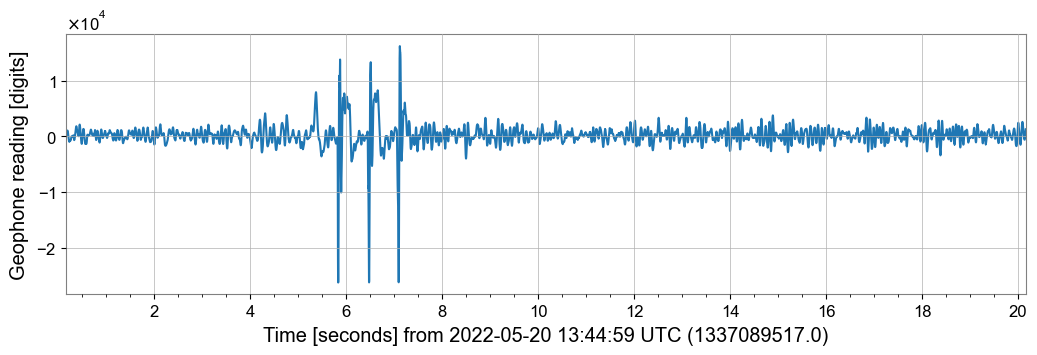

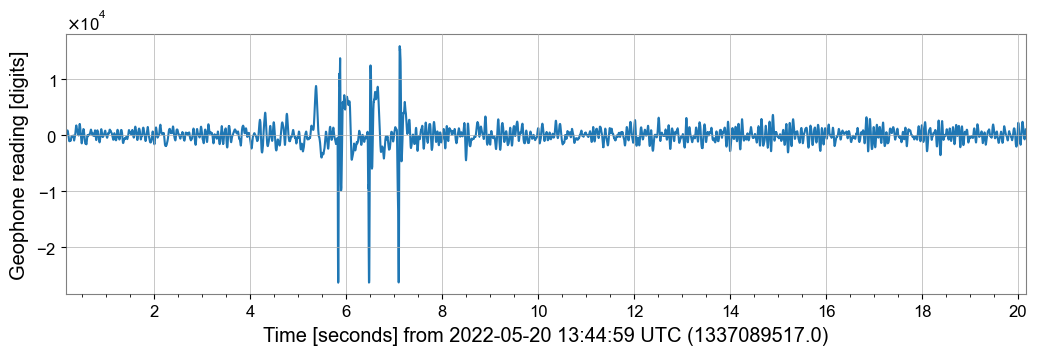

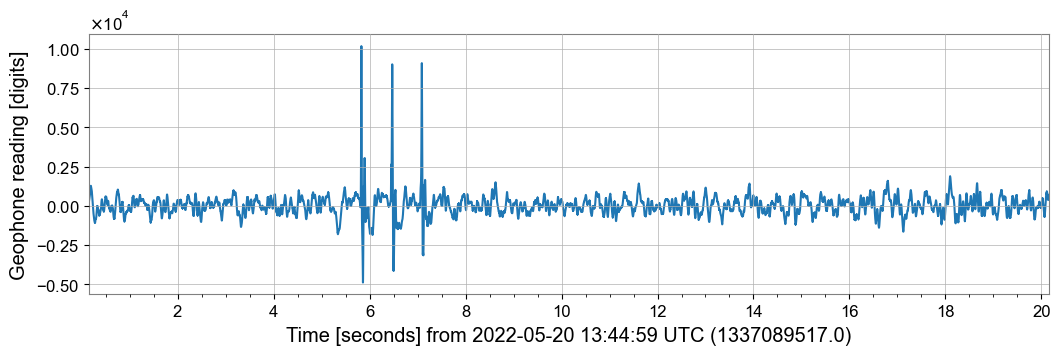

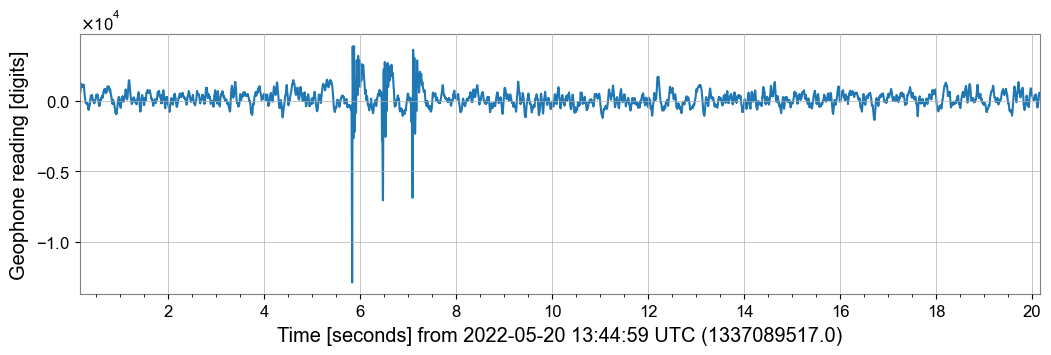

In [6]:
from spicypy.signal.time_series import TimeSeries
import numpy as np

stacis_time_series_dict = {}

for i,channel in enumerate(stacis_channels):
    ts_array = np.float64(stacis_data_df[3+i].to_numpy())  # '3' is here because data that we need starts from 4th column
    t = TimeSeries(ts_array, t0=start_time, sample_rate=5000, copy=True, name=channel, unit="digit")
    stacis_time_series_dict[channel] = t
    _ = t.plot(ylabel = "Geophone reading [digits]")
    

Let's compute PSD in one channel and plot it

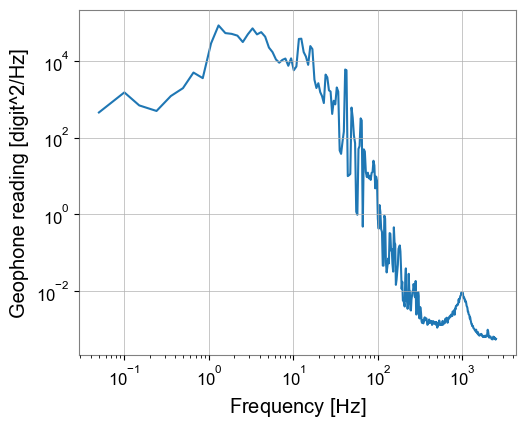

In [7]:
_ = stacis_time_series_dict["Geo1X"].psd(method="lpsd").plot(ylabel = "Geophone reading [digit^2/Hz]")

Seismic data is normally sampled at 100 HZ. Let's resample data and see how PSD changes. Default argument values include ``window='hamming', ftype='fir'``

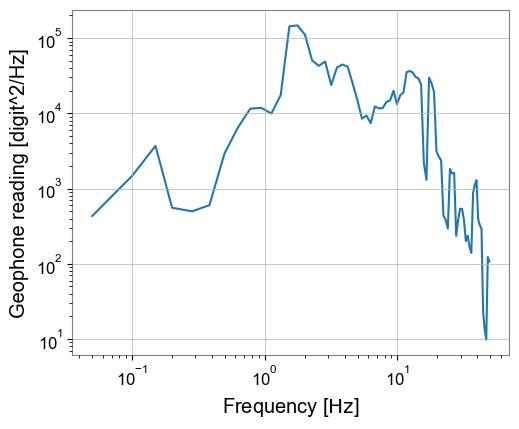

In [8]:
downsampled_ts = stacis_time_series_dict["Geo1X"].resample(100)
_ =downsampled_ts.psd(method="lpsd").plot(ylabel = "Geophone reading [digit^2/Hz]")

In the beginning of the data we jumped nearby 3 times. Lets zoom in on this area. This can be used to do matched filtering to align signals time-wise.

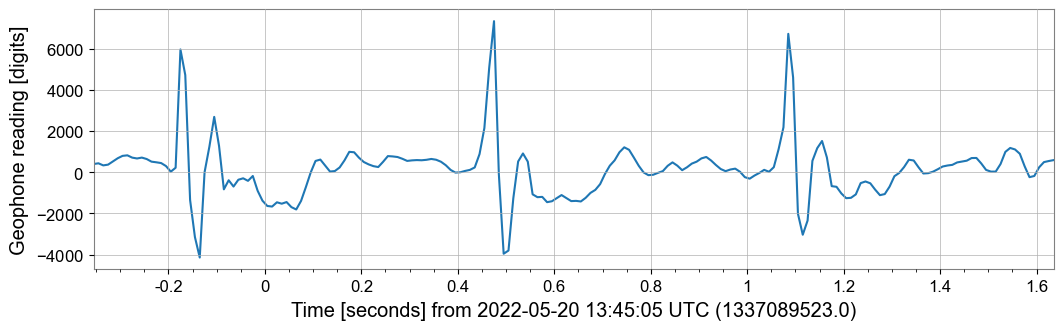

In [9]:
_ =downsampled_ts.crop(start_time+5.5, start_time+7.5).plot(ylabel = "Geophone reading [digits]")

## Matched filtering and coherence

Let's try to do matched filtering for 2 geophones along the same axis `Geo1X` and `Geo2X`, just as an exercise. Before doing template matching, whithen both time series

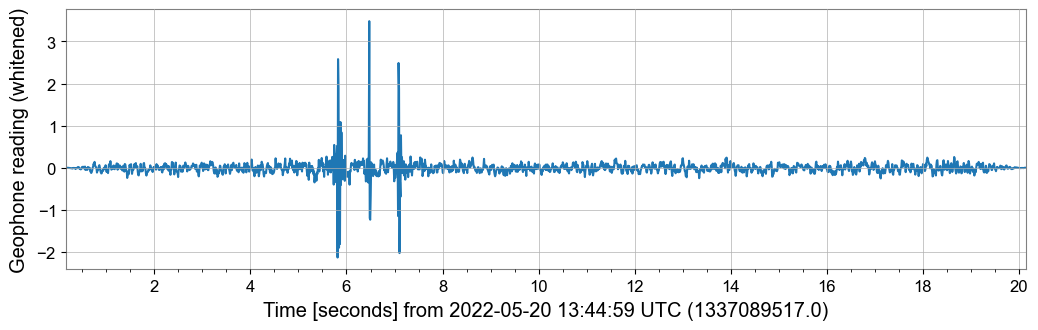

In [10]:
geo1x_white = stacis_time_series_dict["Geo1X"].whiten(8, 4).resample(100)
geo2x_white = stacis_time_series_dict["Geo2X"].whiten(8, 4).resample(100)
_ = geo1x_white.plot(ylabel = "Geophone reading (whitened)")
_ = geo2x_white.plot(ylabel = "Geophone reading (whitened)")

Find SNR peak with a filter consisting of these 3 "calibration" peaks

C:\Users\basalaea\.conda\envs\old\lib\site-packages\gwpy\plot\plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


Max SNR =  7.156688646427263 at # 650
Match time (GPS) 1337089523.6539938


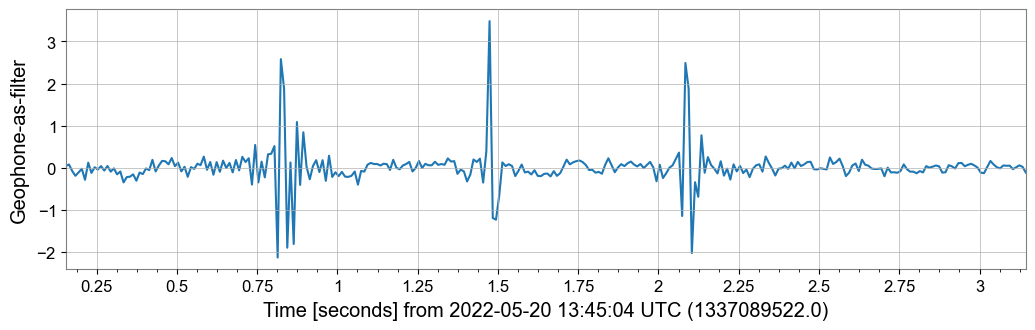

In [11]:
geo1x_filter = geo1x_white.crop(start_time+5,start_time+8)
geo1x_filter.sample_rate = geo1x_white.sample_rate # due to numeric issue in GWpy, sample rate ends up slightly different after cropping
_ = geo1x_filter.plot(ylabel = "Geophone-as-filter")
snr = geo2x_white.correlate(geo1x_filter).abs()

plot = snr.plot()
plot.axes[0].set_ylabel('Signal-to-noise ratio', fontsize=16)
plot.show()

import numpy
print("Max SNR = ", numpy.max(snr.value), "at #", numpy.argmax(snr.value))

match_time = snr.times[numpy.argmax(snr.value)].value
print("Match time (GPS)", match_time)

Calculate coherence betwen original signals

In [12]:
coherence = stacis_time_series_dict["Geo1Y"].coherence(stacis_time_series_dict["Geo2Y"], method="lpsd")
plot = coherence.plot()
ax = plot.gca()
ax.set_ylabel("Coherence")

Text(0, 0.5, 'Coherence')